### Neflix Movie Recommendation

The project is to develop movie recommendation for Netflix. The dataset has been downloaded from Kaggle.

### Loading Data

#### Importing Requried Packages

In [1]:
import pandas as pd
import numpy as np
import math
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import sys
#!{sys.executable} -m pip install surprise
from surprise import Reader, Dataset, SVD
sns.set_style("darkgrid")

#### Let's have a look at the dataset 

- MovieIDs range from 1 to 17770 sequentially.
- CustomerIDs range from 1 to 2649429, with gaps. There are 480189 users.
- Ratings are on a five star (integral) scale from 1 to 5.
- Dates have the format YYYY-MM-DD.

In [2]:
df1 = pd.read_csv('./data/combined_data_1.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
df1['Rating'] = df1['Rating'].astype(float)
df = df1
df.index = np.arange(0,len(df))
df

,Cust_Id,Rating
0,1:,NaN
1,1488844,3.0
2,822109,5.0
3,885013,4.0
4,30878,4.0
...,...,...
24058258,2591364,2.0
24058259,1791000,2.0
24058260,512536,5.0
24058261,988963,3.0


### Data Preparation

We see that Cust_Id has movie_id on the top and ratings for that movie given by several customers. We need to create a new column for Movie_Id. Let us see how we can achieve that.

#### Let us see which row index in df contains the movie information

In [3]:
df_nan = pd.DataFrame(pd.isnull(df.Rating))
df_nan = df_nan[df_nan['Rating'] == True]
df_nan = df_nan.reset_index()
df_nan = df_nan.rename(columns={"index":"movie_index"})
df_nan

,movie_index,Rating
0,0,True
1,548,True
2,694,True
3,2707,True
4,2850,True
...,...,...
4494,24046714,True
4495,24047329,True
4496,24056849,True
4497,24057564,True


#### Logic to create a Movie_Id column

Let us create an array which will have movie_id=1 from 0 to 547, movie_id=2 from 548 to 693, ..., for movie_id=449 from 24057564 to 24057834. We will do that using np.full function. 

- np.full(((1,5), 1) will give the result array([[1, 1, 1, 1, 1]])
- for movie_id = 1, it will be np.full((1, 548-0-1), movie_id)
- for movie_id = 2, it will be np.full((1, 694-584-1), movie_id)

...

- for movie_id = 4499, it will be np.full((1, 24057834-24057564-1), movie_id)
However for the movie_id, we need to include starting 24057564 record until the last record in df.

In [4]:
movie_pos = df_nan['movie_index'].tolist()
movie_pos.append(len(df))

movie_ids = []
movie_id = 1
for i in range(len(movie_pos)-1):   
    temp = np.full((1, movie_pos[i+1] - movie_pos[i]), movie_id)
    movie_ids = np.append(movie_ids, temp)
    movie_id += 1      

#### Let us have a look at the Movie_id column

In [5]:
df['Movie_Id'] = movie_ids.astype(int)
df

,Cust_Id,Rating,Movie_Id
0,1:,NaN,1
1,1488844,3.0,1
2,822109,5.0,1
3,885013,4.0,1
4,30878,4.0,1
...,...,...,...
24058258,2591364,2.0,4499
24058259,1791000,2.0,4499
24058260,512536,5.0,4499
24058261,988963,3.0,4499


In [6]:
#### Let us Remove the rows with movie info.  
df = df[pd.notnull(df['Rating'])]
df

,Cust_Id,Rating,Movie_Id
1,1488844,3.0,1
2,822109,5.0,1
3,885013,4.0,1
4,30878,4.0,1
5,823519,3.0,1
...,...,...,...
24058258,2591364,2.0,4499
24058259,1791000,2.0,4499
24058260,512536,5.0,4499
24058261,988963,3.0,4499


### Summarizing Data

#### Count of Movies, Unique Customers, Ratings 

In [7]:
## Count of Movies
count_NaN = df.isnull().sum()
movie_count = count_NaN[1]

## Unique Customers
customer_count = df['Cust_Id'].nunique() - movie_count

## Count of ratings Given by Customers
rating_count = df['Cust_Id'].count() - movie_count

#### Summarizing ratings of Netflix movies by customers

We see that customers rating percentage is dropping for Rating < 3.0. The customers could skip rating the bad movies. 

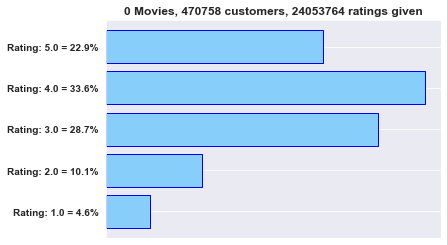

In [8]:
p = df.groupby('Rating')['Rating'].agg(['count'])
p['perc'] = p['count'] / rating_count * 100
new_labels = [f'Rating: {i} = {j:.1f}%' for i, j in zip(p.index, p.perc)]

fig, ax = plt.subplots();
plt.barh(p.index, p.perc, color='lightskyblue', edgecolor='blue');
plt.yticks(range(1, len(p.index)+1), new_labels, fontweight='bold');
ax.axes.get_xaxis().set_visible(False);
plt.title(f'{movie_count} Movies, {customer_count} customers, {rating_count} ratings given', fontsize=12, fontweight='bold');


### Reducing the Data Size

The data size is huge. We need to come up with approaches that reduces the data size.

- Removing inactive customers (i.e. a customer who gives less notice) -70th percentile
- Removing unpopular movies (i.e. with too few reviews) - 70th percentile

In [9]:
## Identify the 70th percentile for customer list
df_cust_summary = df.groupby('Cust_Id')['Rating'].agg(['count','mean'])
cust_benchmark = round(df_cust_summary['count'].quantile(0.7),0)
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index

## Identify the 70th percentile for Movie list
df_movie_summary = df.groupby('Movie_Id')['Rating'].agg(['count','mean'])
movie_benchmark = round(df_movie_summary['count'].quantile(0.7),0)
drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index

print(f'Customers with less than {cust_benchmark} reviews will be removed')
print(f'Customers with less than {movie_benchmark} reviews will be removed')

Customers with less than 52.0 reviews will be removed
Customers with less than 1799.0 reviews will be removed


In [11]:
df = df[~df['Movie_Id'].isin(drop_movie_list)]
df = df[~df['Cust_Id'].isin(drop_cust_list)]
df

,Cust_Id,Rating,Movie_Id
696,712664,5.0,3
697,1331154,4.0,3
698,2632461,3.0,3
699,44937,5.0,3
700,656399,4.0,3
...,...,...,...
24056841,520675,3.0,4496
24056842,1055714,5.0,4496
24056843,2643029,4.0,4496
24056845,1559566,3.0,4496


### Netflix Recommendation Algorithm

#### Method 1: Recommend Movies using Pearson's R Correlation

Let us start recommending movies using Pearson's R Correlation. We are going to measure the linear correlation between review 
scores of all pairs of movies. Then we will display top 10 movies with highest correlation.

In [12]:
df_p = pd.pivot_table(df,values='Rating',index='Cust_Id',columns='Movie_Id')
df_title = pd.read_csv('./data/movie_titles.csv', encoding = "ISO-8859-1", header = None, 
                       names = ['Movie_Id', 'Year', 'Name'], index_col = [0])

In [19]:
print(df_title.head())
df_p.head()

            Year                          Name
Movie_Id                                      
1         2003.0               Dinosaur Planet
2         2004.0    Isle of Man TT 2004 Review
3         1997.0                     Character
4         1994.0  Paula Abdul's Get Up & Dance
5         2004.0      The Rise and Fall of ECW


Movie_Id,3,8,16,17,18,26,28,30,32,33,...,4472,4474,4478,4479,4485,4488,4490,4492,4493,4496
Cust_Id,,,,,,,,,,,,,,,,,,,,,
1000033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000062,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,...,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000079,NaN,NaN,NaN,NaN,NaN,NaN,2.0,4.0,NaN,NaN,...,3.0,NaN,NaN,4.0,NaN,2.0,NaN,NaN,NaN,NaN
1000084,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN


#### Identify the movie id based on User Selection

In [26]:
def recommend(movie_title, min_count):
    print("For movie ({})".format(movie_title))
    print("- Top 10 movies recommended based on Pearsons'R correlation - ")
    i = int(df_title.index[df_title['Name'] == movie_title][0])
    target = df_p[i]
    similar_to_target = df_p.corrwith(target)
    corr_target = pd.DataFrame(similar_to_target, columns = ['PearsonR'])
    corr_target.dropna(inplace = True)
    corr_target = corr_target.sort_values('PearsonR', ascending = False)
    corr_target.index = corr_target.index.map(int)
    corr_target = corr_target.join(df_title).join(df_movie_summary)[['PearsonR', 'Name', 'count', 'mean']]
    print(corr_target[corr_target['count']>min_count][:10].to_string(index=False))
    
    
recommend(movie_title = 'Character', min_count = 0)    

For movie (Character)
- Top 10 movies recommended based on Pearsons'R correlation - 
 PearsonR                                   Name  count     mean
 1.000000                              Character   2012 3.641153
 0.714448 The Autobiography of Miss Jane Pittman   2047 3.983879
 0.713041               Father's Little Dividend   1947 3.312275
 0.712606                      Operation Pacific   1839 3.762915
 0.693215                       Samurai Champloo   2000 4.467500
 0.691037                     Holiday in the Sun   1931 3.365096
 0.686939                     Spencer's Mountain   2624 3.848323
 0.681311                           MI-5: Vol. 2   1891 4.143839
 0.681279                     Foyle's War: Set 2   2475 4.249293
 0.681250    U2: Go Home: Live From Slane Castle   1987 4.035732
